# Training의 Debugger 결과 분석

이전 노트북에서 debugger 산출물이 있는 경우에만 이 노트북에서 Debugger 결과를 분석할 수 있습니다.

In [1]:
%store -r

In [2]:
print(training_job_debugger_artifacts_path)

s3://sagemaker-us-east-1-322537213286/tensorflow-training-2020-08-01-07-08-31-216/debug-output


## Tensors 분석

분석을 수행하기 전에 분석에 도움이 되는 Debugger의 개념을 아래 설명합니다.

* **Trial** - Tensor에 액세스 할 때 Debugger API의 핵심 요소이며, training job의 단일 실행을 나타내는 high-level 추상화 객체입니다. Training job에서 도출된 모든 Tensor와 연계됩니다.
* **Step** - 다음 추상화 수준의 객체이며, Debugger에서 step은 Training job의 단일 배치를 나타냅니다. 각 Trial은 여러 단계가 있으며, 각 Tensor는 여러 단계와 연계되고, 각 단계에서 특정 값을 가지게 됩니다.
* **Tensor** - Training job 동안 저장되는 실제 Tensor를 나타내는 객체이며, tensor는 1-D scalar도 가능합니다.(loss는 scalar로 저장됩니다.)

Debugger API에 대한 상세 내용은 [Amazon SageMaker Debugger github](https://github.com/awslabs/sagemaker-debugger)를 참조하십시오.

In [3]:
from smdebug.trials import create_trial

# this is where we create a Trial object that allows access to saved tensors
trial = create_trial(training_job_debugger_artifacts_path)

[2020-08-01 07:21:42.656 ip-172-16-33-149:22672 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-322537213286/tensorflow-training-2020-08-01-07-08-31-216/debug-output


In [4]:
for i in trial.tensor_names():
    print(i)

[2020-08-01 07:21:43.462 ip-172-16-33-149:22672 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2020-08-01 07:21:44.480 ip-172-16-33-149:22672 INFO trial.py:210] Loaded all steps
accuracy
batch
loss
size
val_accuracy
val_loss


In [5]:
import pandas as pd

def get_data(trial, tensor_name, batch_index, steps_range, mode):
    tensor = trial.tensor(tensor_name)
    vals = []
    for step_num in steps_range:
        val = tensor.value(step_num=step_num, mode=mode)[batch_index]
        vals.append(val)
    return pd.DataFrame(columns=['steps', tensor_name], data=list(zip(steps_range, vals)))

In [6]:
from smdebug.tensorflow import modes
import time

# Below we select the very first tensor from every batch.
# Feel free to modify this and select another tensor from the batch.
batch_index = 0

# This is a name of a tensor to analyze.
tensor_name = 'accuracy'

steps = 0
while steps == 0:
    # trial.steps return all steps that have been downloaded by Debugger to date.
    # It doesn't represent all steps that are to be available once training job is complete -
    # it is a snapshot of a current state of the training job. If you call it after training job is done
    # you will get all tensors available at once.
    steps = trial.steps()
    print('Waiting for tensors to become available...')
    time.sleep(3)
print('\nDone')

print('Getting tensors...')
rendered_steps = []

# trial.loaded_all_steps is a way to keep monitoring for a state of a training job as seen by Debugger.
# When SageMaker completes training job Debugger, and trial, becomes aware of it.

loaded_all_steps = False
while not loaded_all_steps:
    loaded_all_steps = trial.loaded_all_steps
    steps = trial.steps()
    # show diff between lists
    steps_to_render = list(set(steps).symmetric_difference(set(rendered_steps)))
    
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=0, 
                    steps_range=steps_to_render, 
                    mode=modes.GLOBAL)
    print(data)
#     data.sort_values('steps', inplace=True)
#     data.plot(x='steps', y=tensor_name)
    
    rendered_steps.extend(steps_to_render)
    time.sleep(5)
    

Waiting for tensors to become available...

Done
Getting tensors...
    steps  accuracy
0       0  0.265625
1     130  0.599798
2      99  0.567813
3     100  0.593750
4      70  0.666295
5      40  0.558689
6      10  0.417614
7     140  0.600038
8     110  0.600142
9      80  0.667087
10     50  0.679688
11     20  0.508557
12    120  0.600818
13     90  0.666540
14     60  0.666193
15     30  0.540827


## Visualize Loss

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99, 100, 110, 120, 130, 140]
    steps      loss
0       0  1.598267
1      10  1.572109
2      20  1.520848
3      30  1.489113
4      40  1.442526
5      50  1.394780
6      60  1.402569
7      70  1.397953
8      80  1.394780
9      90  1.402569
10     99  1.511489
11    100  1.433697
12    110  1.431864
13    120  1.423805
14    130  1.433697
15    140  1.431864


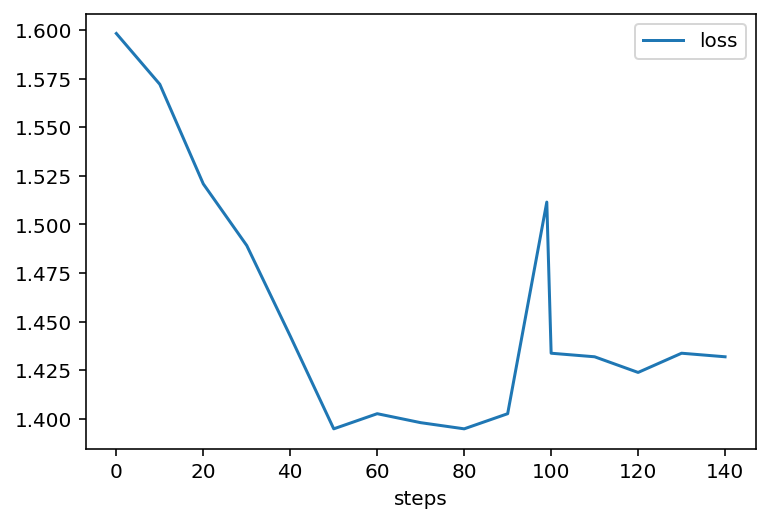

In [7]:
from smdebug.tensorflow import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from matplotlib import pyplot as plt

import pandas as pd

# Let's visualize weights of the first convolutional layer as they progressively change through training.
tensor_name = 'loss'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)

## Visualize Accuracy

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 99, 100, 110, 120, 130, 140]
    steps  accuracy
0       0  0.265625
1      10  0.417614
2      20  0.508557
3      30  0.540827
4      40  0.558689
5      50  0.679688
6      60  0.666193
7      70  0.666295
8      80  0.667087
9      90  0.666540
10     99  0.567813
11    100  0.593750
12    110  0.600142
13    120  0.600818
14    130  0.599798
15    140  0.600038


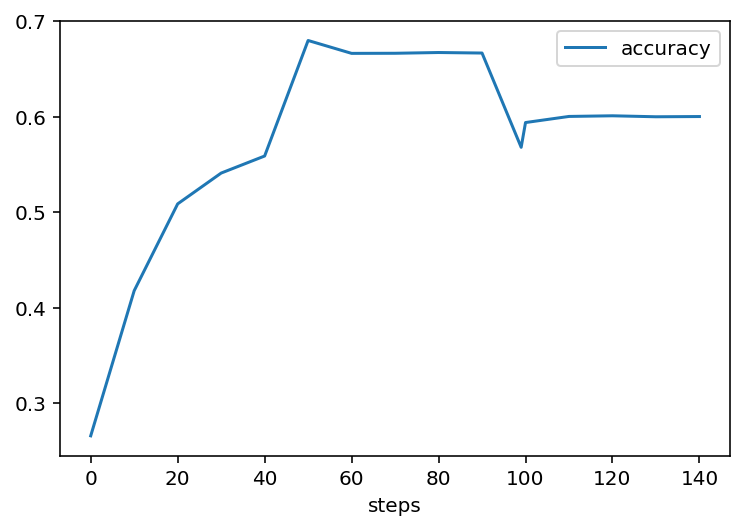

In [8]:
from smdebug.tensorflow import modes
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#from matplotlib import pyplot as plt

import pandas as pd

tensor_name = 'accuracy'

num_batches = trial.tensor(tensor_name).value(step_num=steps[0]).shape[0]
for batch_index in range(0, num_batches):
    steps_range = trial.tensor(tensor_name).steps()
    print(steps_range)
    data = get_data(trial=trial, 
                    tensor_name=tensor_name, 
                    batch_index=batch_index, 
                    steps_range=steps_range, 
                    mode=modes.GLOBAL)
    print(data)
    data.plot(x='steps', y=tensor_name)